# Spatial Trascriptomics Analysis of Human Lung Data

## Introduction

Here, I look into a tissue slice from the human lung. This is based on a study by Murthy *et al.*,  2022 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9169066/). The data was accessed from the following source:

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE178361

### Create working directory

First, set up a output directory where you will save your data and results files:

In [2]:
import os

outdir = "path/to/outs"
os.makedirs(outdir, exist_ok=True)

In [59]:
!pwd

/mnt/storage/r0917237/jupyternotebooks


## Data loading

I have loaded a directory with the output files of the spatial transcriptomics data; it was found resembling the SpaceRanger output, so I asssume that that is how the authors generated it.

In [2]:
import os

path_data = "/mnt/storage/r0917237/regulatoryGenomics2023/SpatialTrascriptomics/assignment1/lung/DD073R_A1_processed"

os.listdir(path_data)

['filtered_feature_bc_matrix.h5', 'raw_feature_bc_matrix.h5', 'spatial']

The Space Ranger pipeline outputs unfiltered `raw_feature_bc_matrix` and filtered feature-barcode `filtered_feature_bc_matrix` matrices, together with a subdirectory named `spatial`, which stores spatial related files beside which we find:
- `tissue_hires_image.png` and `tissue_lowres_image.png`: downsampled versions of the full resolution H&E stain
- `tissue_positions.csv`: table containing the position of the barcoded spots on the image

To read this data, we use the SCANPY `sc.read_visium` function

In [3]:
import scanpy as sc

adata = sc.read_visium(path = path_data)
adata.var_names_make_unique()
adata

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1175 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

SCANPY uses AnnData objects to represent spatial data (https://anndata.readthedocs.io/en/latest/). In addition to the gene expression matrix, for spatial data it stores along X,Y positions of barcoded spots as observations `obs`, and their image coordinates in `.obsm['spatial']`.
High and low resolution H&E images are stored in `.uns['spatial']`, together with their relative scale factors and metadata.

In [102]:
adata.uns['spatial']['DD73RA1_rep2'].keys()

dict_keys(['images', 'scalefactors', 'metadata'])

## Visulization of Spatial Trascriptomics data
I use `sc.pl.spatial` function to overlay barcoded spots on top of the Hematoxylin and eosin stain (H&E) image provided. The function `sc.pl.spatial` accepts an additional paremeter named `color` to display annotations of observations or genes. Here, I plot the first three genes loaded from the dataset, but as is visible here from the colour and also the scale on the right of all images, these genes appear to not be expressed at all. Since spatial data is in integer values (number of reads), we should expect a larger scale if genes are expressed at all.

Later, once spatially variable genes are detected, I will plot these.

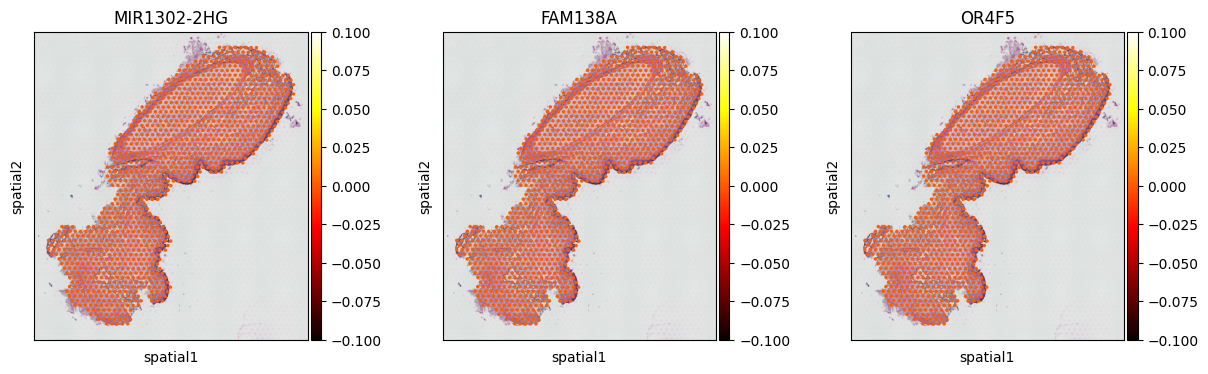

In [103]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

sc.pl.spatial(adata, color=['MIR1302-2HG', 'FAM138A', 'OR4F5'], cmap='hot')

## QC and preprocessing

We look at some statistics: The total counts of genes per spot, the number of counts 

We standard QC metrics with `sc.pp.calculate_qc_metrics` and percentage of mitochondrial read counts per sample. We then plot these using `sc.pl.violin`. Clearly, there are already no mitochondrial genes in the dataset. I would assume that this is because they have been pre-filtered.

In [17]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

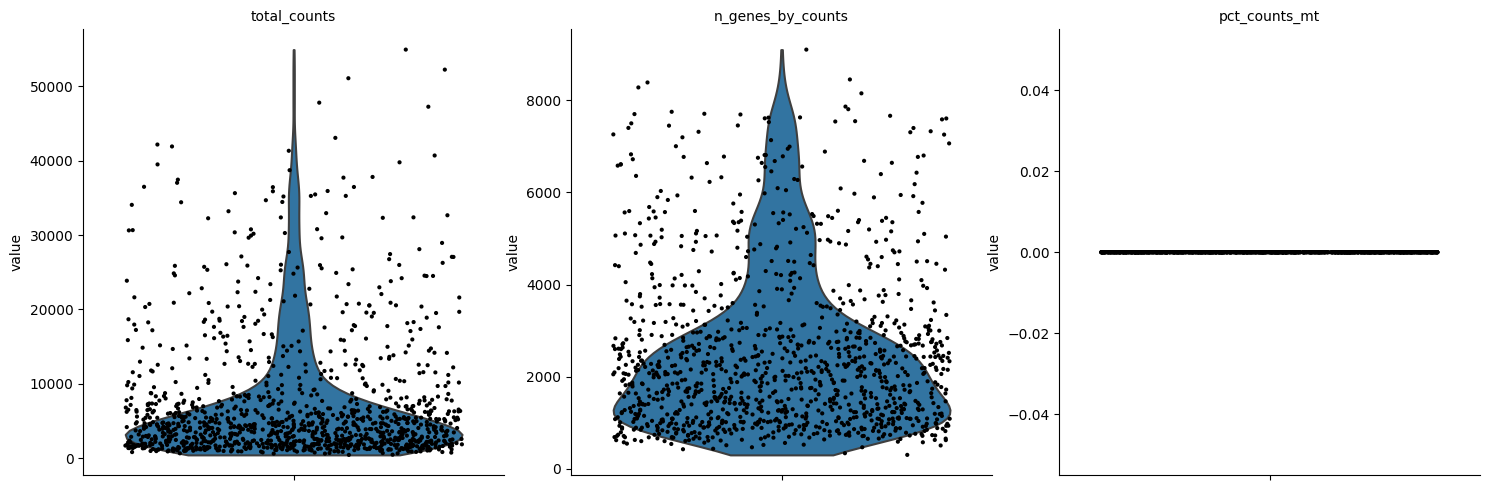

In [18]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size=3)

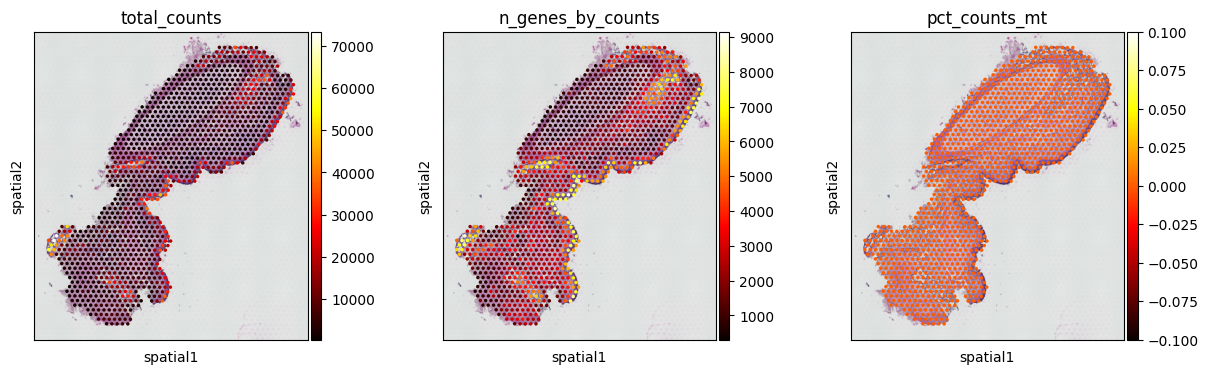

In [106]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, color=["total_counts", "n_genes_by_counts", "pct_counts_mt"], cmap='hot')

Since a single spot can contain multiple cells we do not heavily filter out spots with high counts because they might ovelap with dense tissue areas. We instead set a low threshold for the minimum number of genes and counts required per spot to remove low quality data. We have decided not to filter spots with high mitochondria gene counts because although they might indicate presence of broken or dying cells, we do not notice any specific tissue damage from the H&E image in areas where mitochondria gene counts are high.

**Note**: When cells were filtered by minimum counts, some spots close to the center of the tissue were lost, so I have chosen to not filter spots that have a low number of counts.

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_counts=60000)
#sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=5)

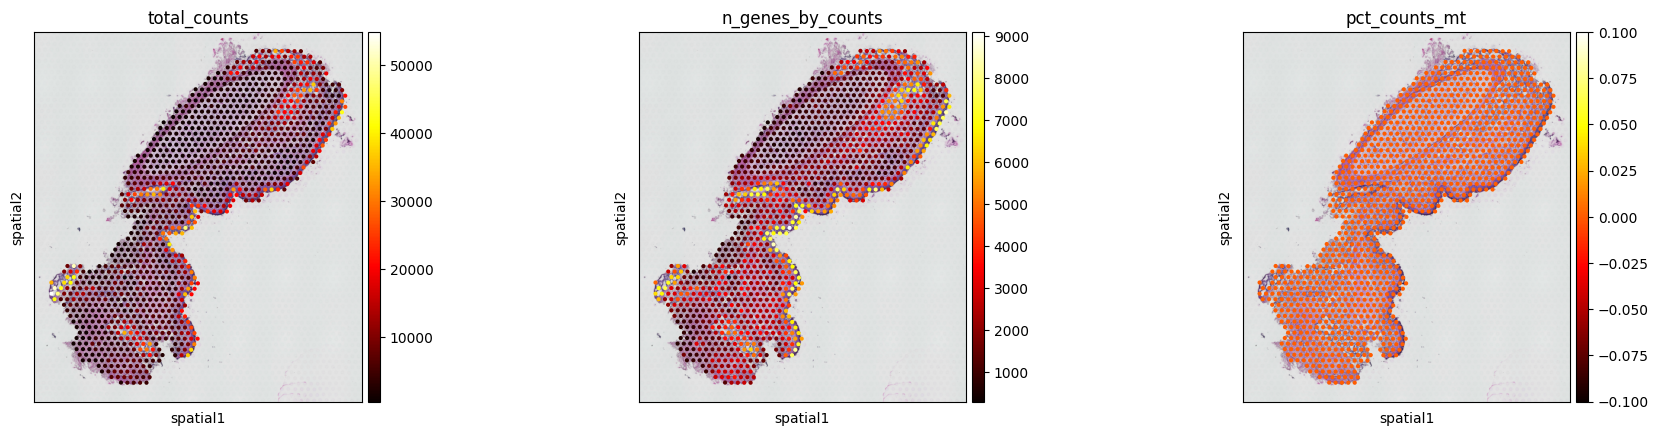

In [19]:
sc.pl.spatial(adata, color=["total_counts", "n_genes_by_counts", "pct_counts_mt"], cmap='hot')

## Normalization
We have seen that total counts (number of UMIs) vary significantly between spots. This is mainly due to the tissue anatomy but also due to technical factors that introduce non biological variations that we wish to remove by normalizing the data with respect to total counts of UMIs per spot.

In [20]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.raw = adata

## Spatially variable genes

We can attempt to locate highly variable genes in the dataset, and plot these out spatially. However, with these, although they may vary greatly across the dataset, they may not indicate spatial patterns very clearly.

In [21]:
# Find highly variable genes
sc.pp.highly_variable_genes(adata)
hvg = adata.var_names[adata.var.highly_variable==True]
adata.var[adata.var.highly_variable==True].head()

gene_ids    feature_types  genome  n_cells     mt  \
LINC01409  ENSG00000237491  Gene Expression  GRCh38       60  False   
LINC01128  ENSG00000228794  Gene Expression  GRCh38       82  False   
MXRA8      ENSG00000162576  Gene Expression  GRCh38      726  False   
TMEM240    ENSG00000205090  Gene Expression  GRCh38       39  False   
MORN1      ENSG00000116151  Gene Expression  GRCh38      125  False   

           n_cells_by_counts  mean_counts  log1p_mean_counts  \
LINC01409                 60     0.058824           0.057158   
LINC01128                 82     0.075021           0.072340   
MXRA8                    726     1.239557           0.806278   
TMEM240                   39     0.036658           0.036002   
MORN1                    125     0.157715           0.146448   

           pct_dropout_by_counts  total_counts  log1p_total_counts  \
LINC01409              94.884910          69.0            4.248495   
LINC01128              93.009378          88.0            4.488636   
MXRA8                  38.107417        1454.0            7.282761   
TMEM240                96.675192          43.0            3.784190   
MORN1                  89.343564         185.0            5.225747   

           highly_variable     means  dispersions  dispersions_norm  
LINC01409             True  0.043072     0.763843          1.167673  
LINC01128             True  0.056883     0.520353          0.562329  
MXRA8                 True  0.838092     0.867392          0.540439  
TMEM240               True  0.027583     0.743212          1.116383  
MORN1                 True  0.081836     0.620361          0.810962

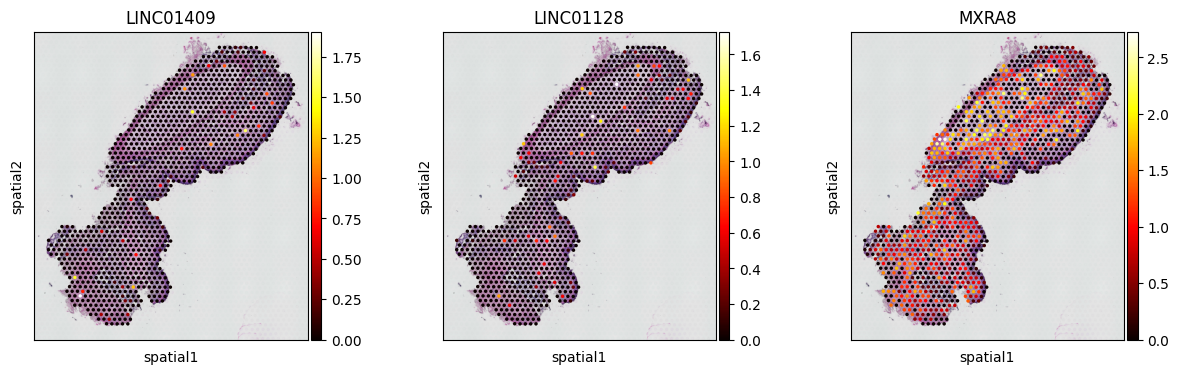

In [77]:
sc.pl.spatial(adata, color=['LINC01409', 'LINC01128', 'MXRA8'], cmap='hot')

In order to identify **spatially variable genes** (SVG), we need to decompose spatial and non-spatial variations in gene expression. Genes that show variatiation in gene expression predominantly due to spatial variation can be said that are spatially variable ([Walker et al., 2022](https://doi.org/10.1038/s42003-022-03175-5)).

We first construct a spatial graph by connecting proximal spots based on their X,Y coordinates. We then compute Morans's I statistics for each gene.

In [22]:
import squidpy as sq

sq.gr.spatial_neighbors(adata) # Build spatial graph
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names) # Moran's I statistic

In [112]:
adata.uns["moranI"]

I  pval_norm  var_norm  pval_norm_fdr_bh
CYTL1     0.856754   0.000000  0.000307          0.000000
LTF       0.806805   0.000000  0.000307          0.000000
CHI3L1    0.800826   0.000000  0.000307          0.000000
SNORC     0.799753   0.000000  0.000307          0.000000
GPX3      0.792071   0.000000  0.000307          0.000000
...            ...        ...       ...               ...
RALGAPA1 -0.041635   0.009938  0.000307          0.038767
ZNF791   -0.042456   0.008760  0.000307          0.034829
RETSAT   -0.044885   0.005964  0.000307          0.025220
PRAF2    -0.046508   0.004568  0.000307          0.020101
FOXK1    -0.051564   0.001892  0.000307          0.009312

[17652 rows x 4 columns]

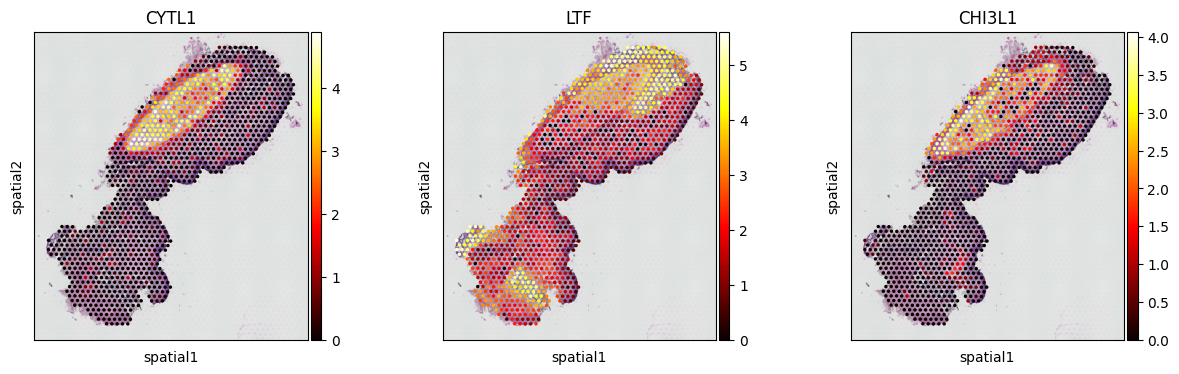

In [113]:
sc.pl.spatial(adata, color=['CYTL1', 'LTF', 'CHI3L1'], cmap='hot')

## Principal components on spatially variable genes

We can compute principal component analysis based on SVG to extract spatially varying components that most likely represent gene programs active in different tissue areas.

We first define SVGs by setting a threhsold on the Moran's I score.

In [23]:
svg = adata.uns["moranI"][adata.uns["moranI"].I>0.5].index.to_list()

In [24]:
len(svg)

91

In [25]:
adata.var.highly_variable = adata.var_names.isin(svg)

We then compute PCA on the SVG and visualize the principal components and their loadings.

In [26]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=20, use_highly_variable=True)

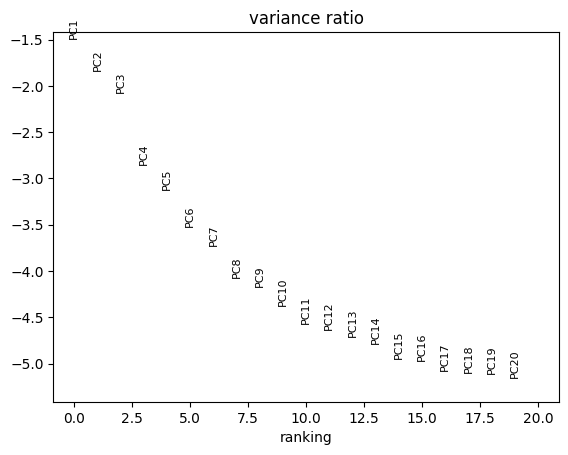

In [27]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=20)

In [28]:
import pandas as pd
import numpy as np

adata.obs = adata.obs.join(pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.index, columns=['PC'+str(x+1) for x in np.arange(adata.varm['PCs'].shape[1])]))

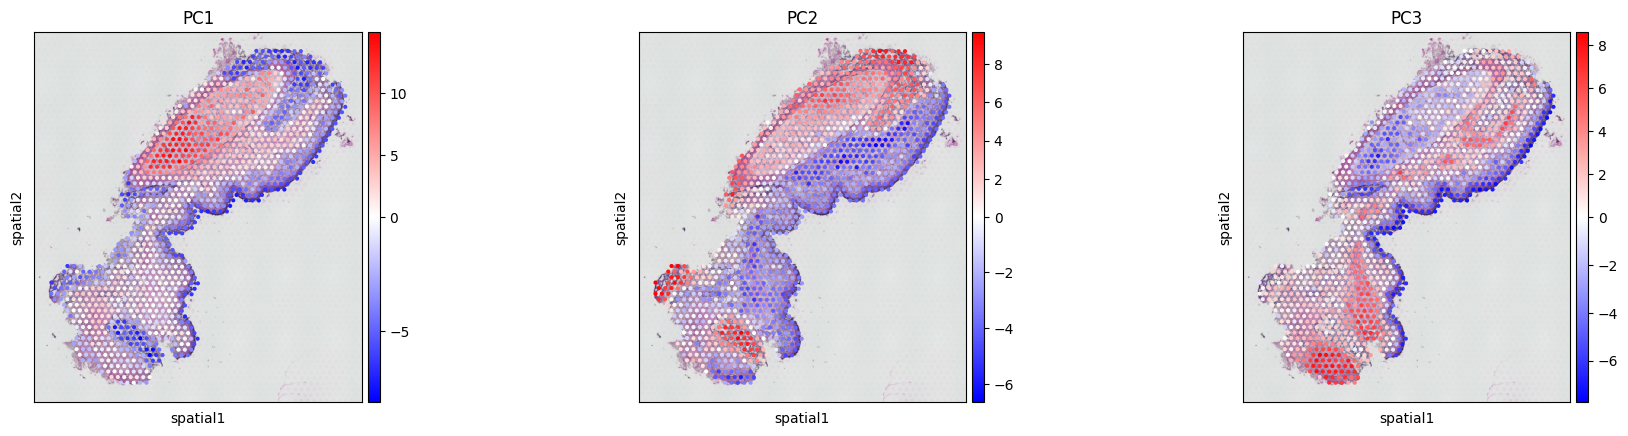

In [29]:
sc.pl.spatial(adata, color=['PC1', 'PC2', 'PC3'], cmap='bwr', vcenter=0)

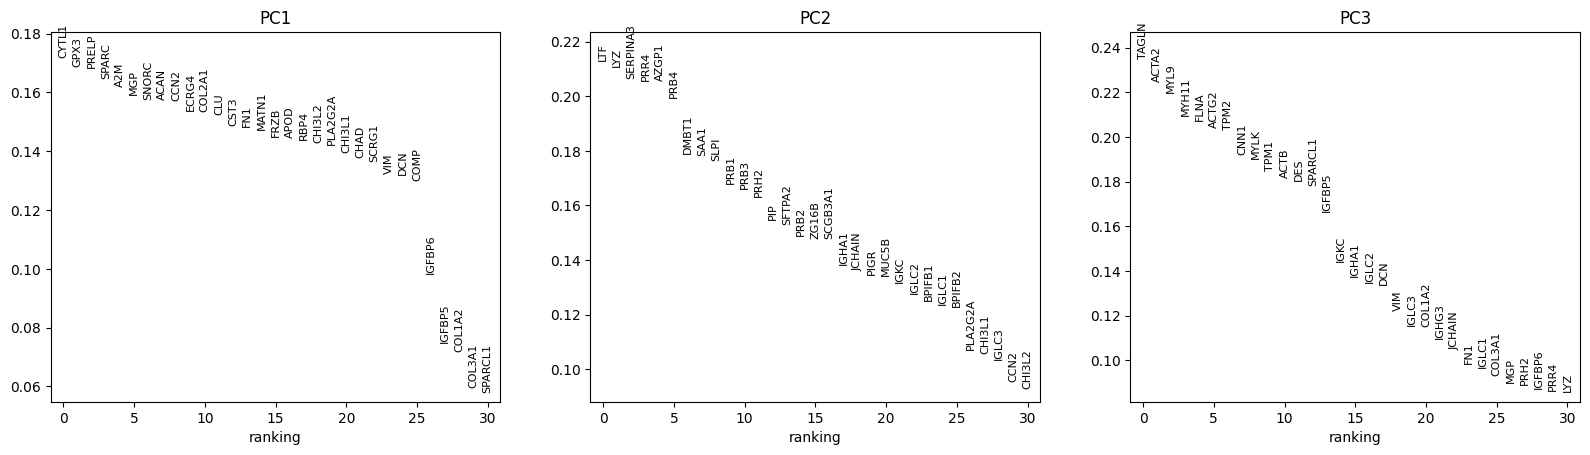

In [30]:
sc.pl.pca_loadings(adata, include_lowest=False)

## Spatial domains
We can now explore how tissue architecture is spatially defined in different compartments with different gene expression and cell-type composition. We thus cluster the spatial data combining the neighborhood graph in pca space with the spatial neighborhood graph in spatial coordinates.

In [31]:
# nearest neighbor graph
sc.pp.neighbors(adata, use_rep='X_pca')
nn_graph_genes = adata.obsp["connectivities"]
# spatial proximity graph
sq.gr.spatial_neighbors(adata)
nn_graph_space = adata.obsp["spatial_connectivities"]

2024-01-06 17:43:28.607191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/.singularity.d/libs
2024-01-06 17:43:28.607232: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [32]:
# Blend neighborhood and spatial neighborhood graph 
alpha = 0.2
joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
# Run leiden clustering
sc.tl.leiden(adata, resolution=1.2, adjacency=joint_graph, key_added="spatial_domains")

In [33]:
sc.tl.umap(adata)

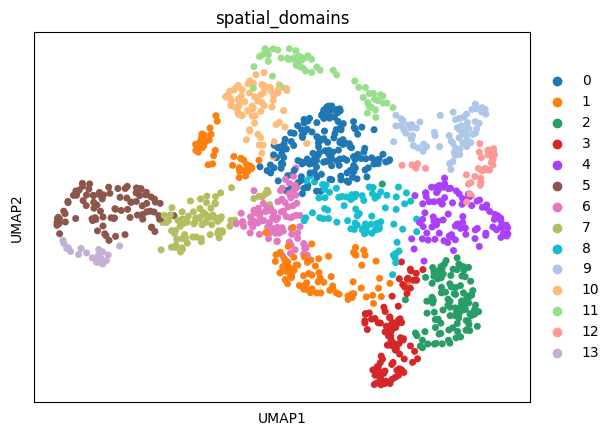

In [34]:
sc.pl.umap(adata, color = 'spatial_domains')

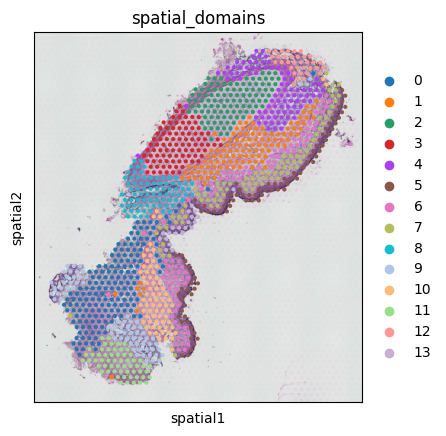

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#path_img = "/mnt/storage/nhecker/images/brain_allen.png"
#img = mpimg.imread(path_img)
#imgplot = ax[0].imshow(img)
sc.pl.spatial(adata, color=["spatial_domains"]
              #, ax=ax[1]
              , show=False)
plt.show()

We can now compute marker genes for these clusters to help us understand their cell-type composition and annotate the different tissue regions.

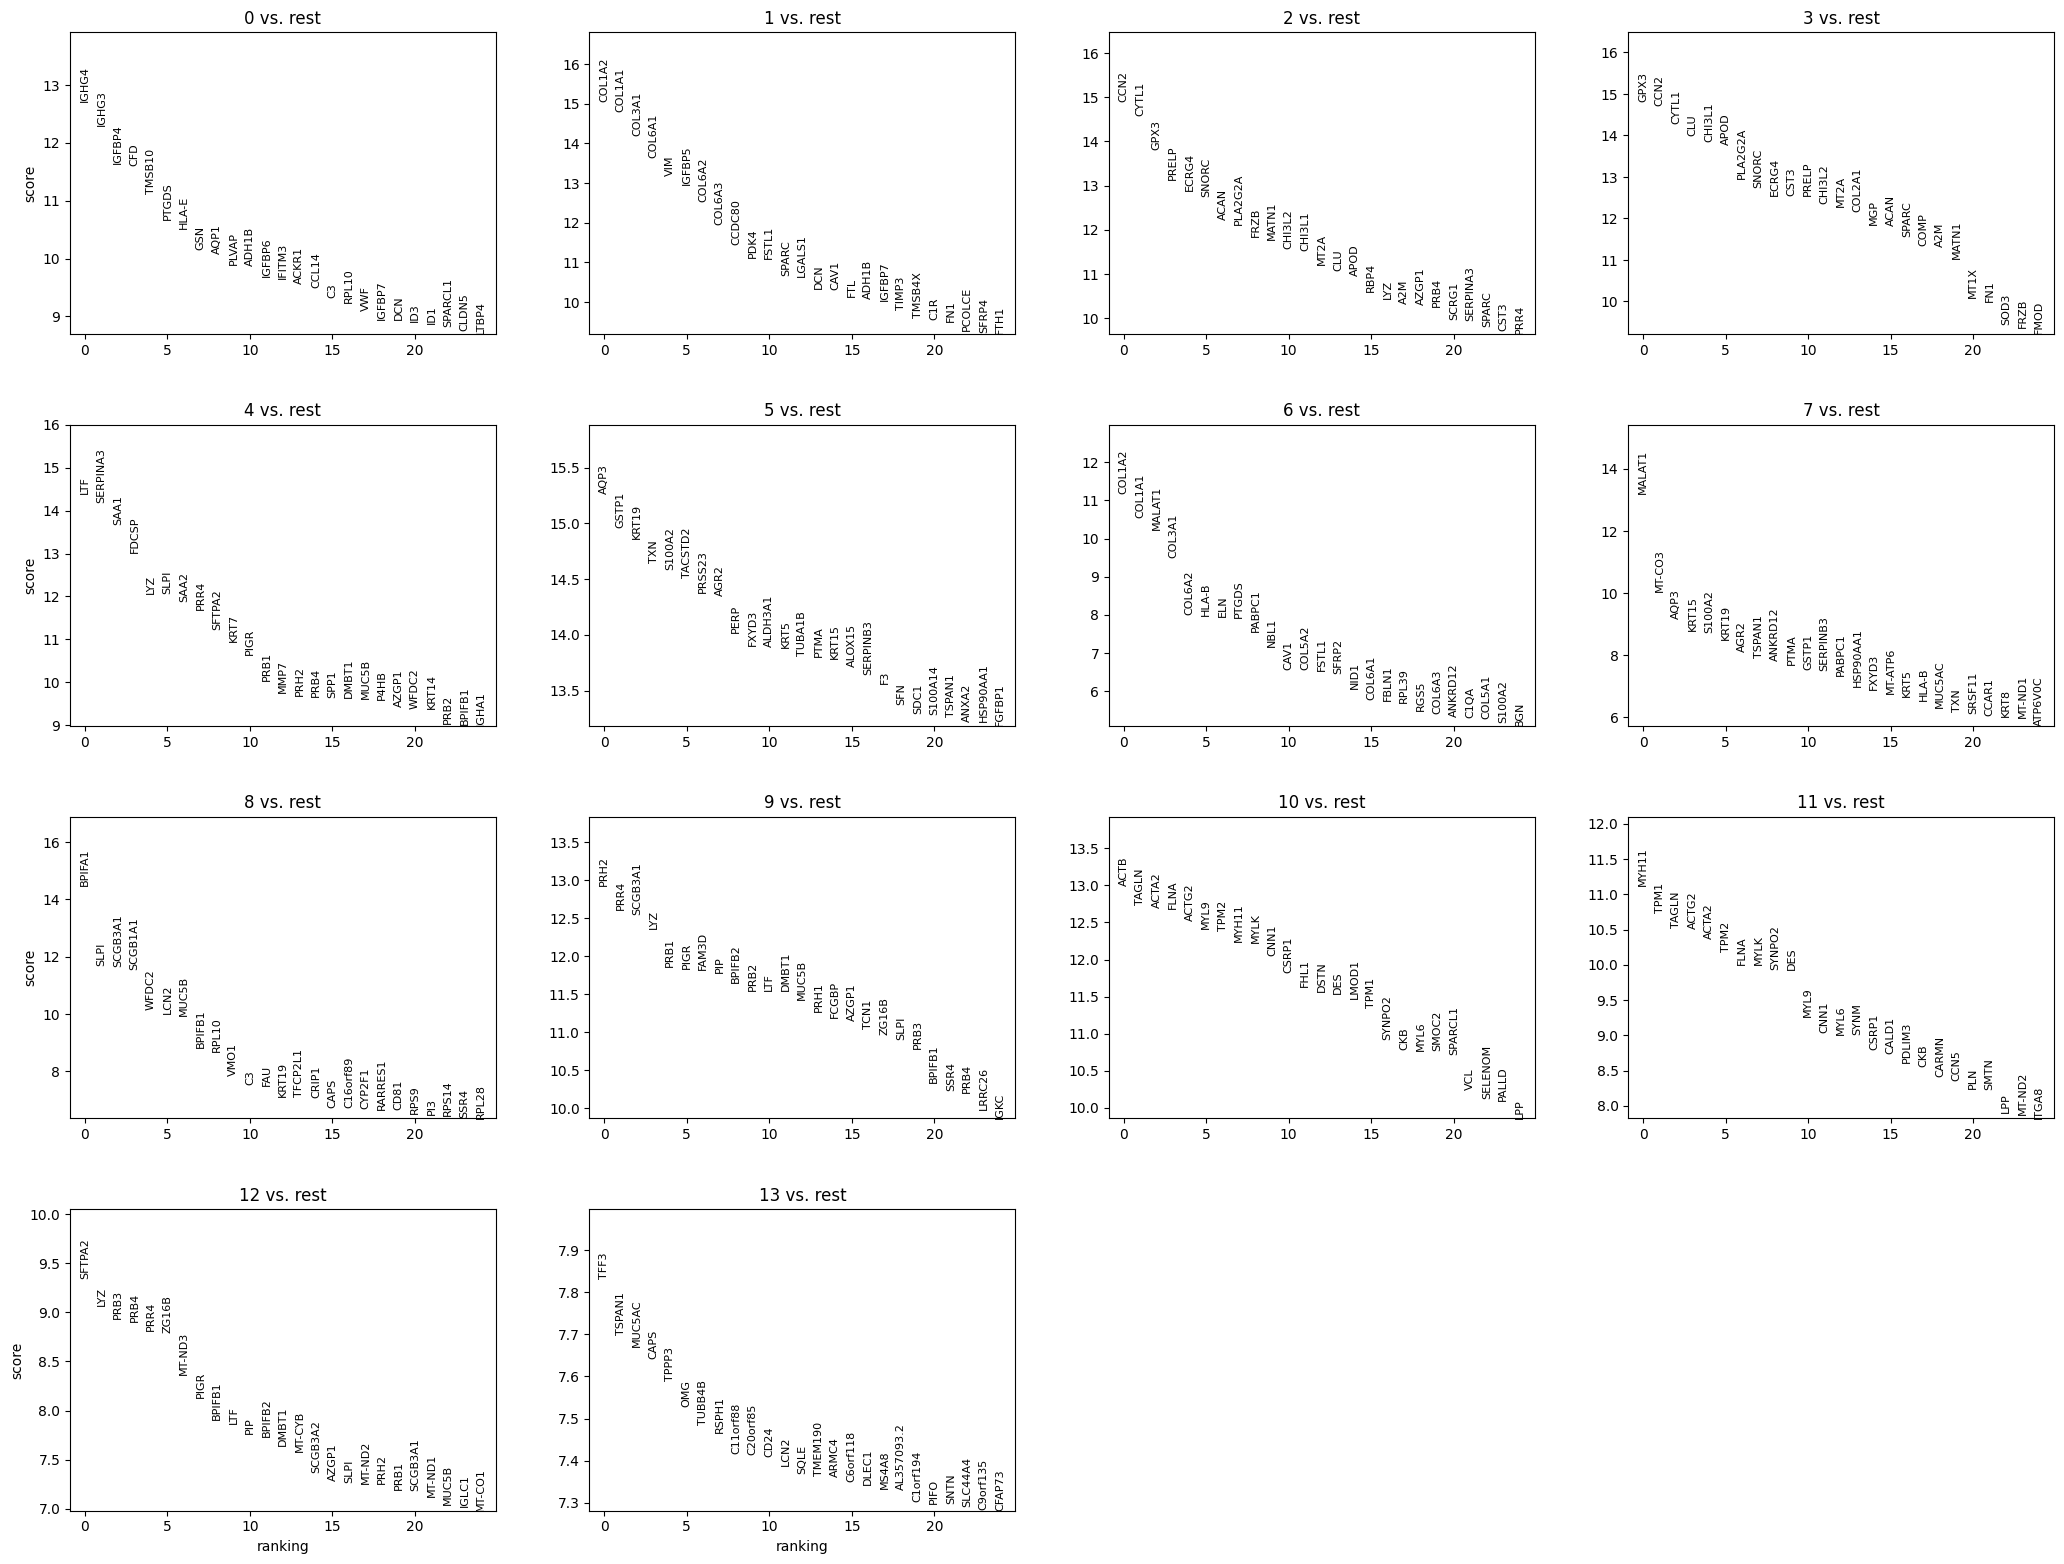

In [36]:
sc.tl.rank_genes_groups(adata, 'spatial_domains', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Cell type annotation

Now that the spots have been successfully clustered on the basis of the expression levels of spatially variable genes, we can attempt to annotate these spots based on the cell types they can contain. 

One approach to this is deconvolution, wherein **annotated** scRNA-seq data is used to link marker gene expression patterns to cell types, following which gene expression patterns on the spatial transcriptomics spots can predict the cell types on these spots. 

The authors of the paper had uploaded their data to GEO, but the data was not annotated, and the annotation methods they used in their paper were not entirely automated using packages; some of it was done manually based on biological insights. I instead chose to use data from a project called LungMAP. The Human Lung Cell Atlas was also an option to use, but I found that the data was difficult to access.

I thus chose to take a look at the spatially clustered spots, and use the top marker genes from these clusters to predict what cell types they might represent. 

Here I load the scRNA-seq data (https://data-browser.lungmap.net/projects).

In [4]:
adata_sc = sc.read('/path/to/single_cell_data.hdf5')

AnnData object with n_obs × n_vars = 347970 × 32284
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'pMT', 'DataID', 'DonorID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'celltype_level3'
    var: '_index', 'features'
    obsm: 'X_pca', 'X_umap'

The dataset is very large and training the model with this would take a very long time, so I check which datasets would be most useful to include.

In [6]:
adata_sc.obs['Dataset'].unique()

array(['CCHMC_LungMAP', 'EGAS00001004082', 'GSE122960', 'GSE134174',
       'GSE135893', 'syn21041850', 'UPenn_LungMAP', 'GSE136831',
       'GSE161382', 'GSE171524'], dtype=object)

In [10]:
# Normalization of scRNA-seq reference
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)

In [12]:
adata_sc

AnnData object with n_obs × n_vars = 347970 × 32284
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'pMT', 'DataID', 'DonorID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'celltype_level3'
    var: '_index', 'features'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

For convenience, I subset it to only include data from the two Lung MAP datasets, as this would speed up the model runtime.

In [40]:
adata_sc = adata_sc[adata_sc.obs['Dataset'].isin(['CCHMC_LungMAP', 'UPenn_LungMAP']), :]

I next subset the genes to the ones shared between the two datasets.

In [37]:
adata_sc = adata_sc[:, adata_sc.var['_index'].isin(adata.var_names)]

View of AnnData object with n_obs × n_vars = 347970 × 17058
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'pMT', 'DataID', 'DonorID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'celltype_level3'
    var: '_index', 'features'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

In [41]:
adata_sc # The dataset is much smaller and easier to train on now

View of AnnData object with n_obs × n_vars = 122445 × 17058
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'pMT', 'DataID', 'DonorID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'celltype_level3'
    var: '_index', 'features'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

We then train a logistic regression model with L1 penalty to classify cell-type from scRNA-seq gene expression data.

In [42]:
from sklearn.linear_model import LogisticRegression

lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear')
lasso_classifier.fit(adata_sc.X, adata_sc.obs.celltype_level1)

LogisticRegression(penalty='l1', solver='liblinear')

We used the trained classifier to predict cell-type labels and cell-type probabilities for the 10X Visium data

In [43]:
y_pred = lasso_classifier.predict(adata[:, adata_sc.var['_index']].X)
y_probs = lasso_classifier.predict_proba(adata[:, adata_sc.var['_index']].X)

In [45]:
cp_df = pd.DataFrame(
    y_probs, columns=np.sort(adata_sc.obs['celltype_level1'].unique())
)

cp_df.index = adata.obs.index

In [46]:
adata.obs['sc_annot'] = y_pred

In [47]:
adata_transfer = adata.copy()
adata_transfer.obs = pd.concat(
    [adata.obs, cp_df], axis=1
)

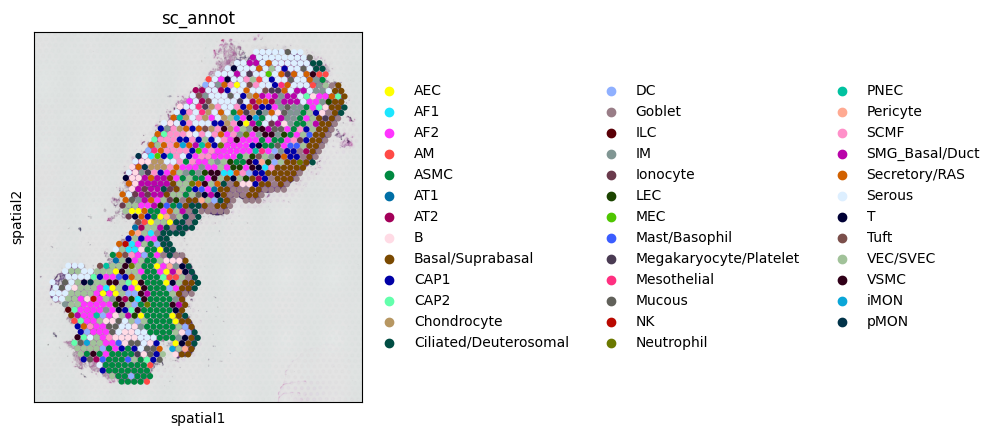

In [48]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=['sc_annot'],
    size=1.5,
)

### Trying the same with broader cell types (lineages)

In [49]:
lasso_broad_classifier = LogisticRegression(penalty='l1', solver='liblinear')
lasso_broad_classifier.fit(adata_sc.X, adata_sc.obs.lineage_level2)

LogisticRegression(penalty='l1', solver='liblinear')

We used the trained classifier to predict cell-type labels and cell-type probabilities for the 10X Visium data

In [50]:
y_pred_broad = lasso_broad_classifier.predict(adata[:, adata_sc.var['_index']].X)
y_probs_broad = lasso_broad_classifier.predict_proba(adata[:, adata_sc.var['_index']].X)

In [51]:
cp_df_broad = pd.DataFrame(
    y_probs_broad, columns=np.sort(adata_sc.obs['lineage_level2'].unique())
)

In [54]:
cp_df_broad.index = adata.obs.index

In [52]:
adata.obs['sc_annot_broad'] = y_pred_broad

In [55]:
adata_transfer_broad = adata.copy()
adata_transfer_broad.obs = pd.concat(
    [adata.obs, cp_df_broad], axis=1
)

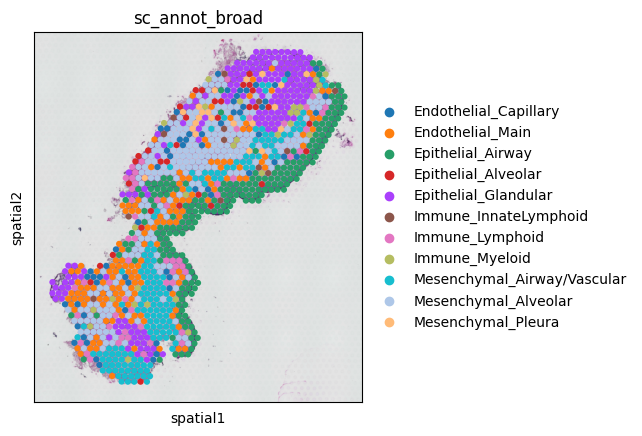

In [56]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=['sc_annot_broad'],
    size=1.5,
)

This looks a lot better than the previous deconvolution with finer cell types. It also corresponds better with the actual cell types detected in the paper. From a biological standpoint as well, these clusters would make more sense in a lung airway. 

It is to be noted, however, that the correspondence is still not very good. This is likely because the authors used scRNA-seq data that they generated, from their own tissues. This would lead to better correspondence between the spatial data and the scRNA-seq data. They also used a combination of machine learning based techniques as well as biologically motivated annotation to label the cells in their data, and to annotate their Visium spots as well.  

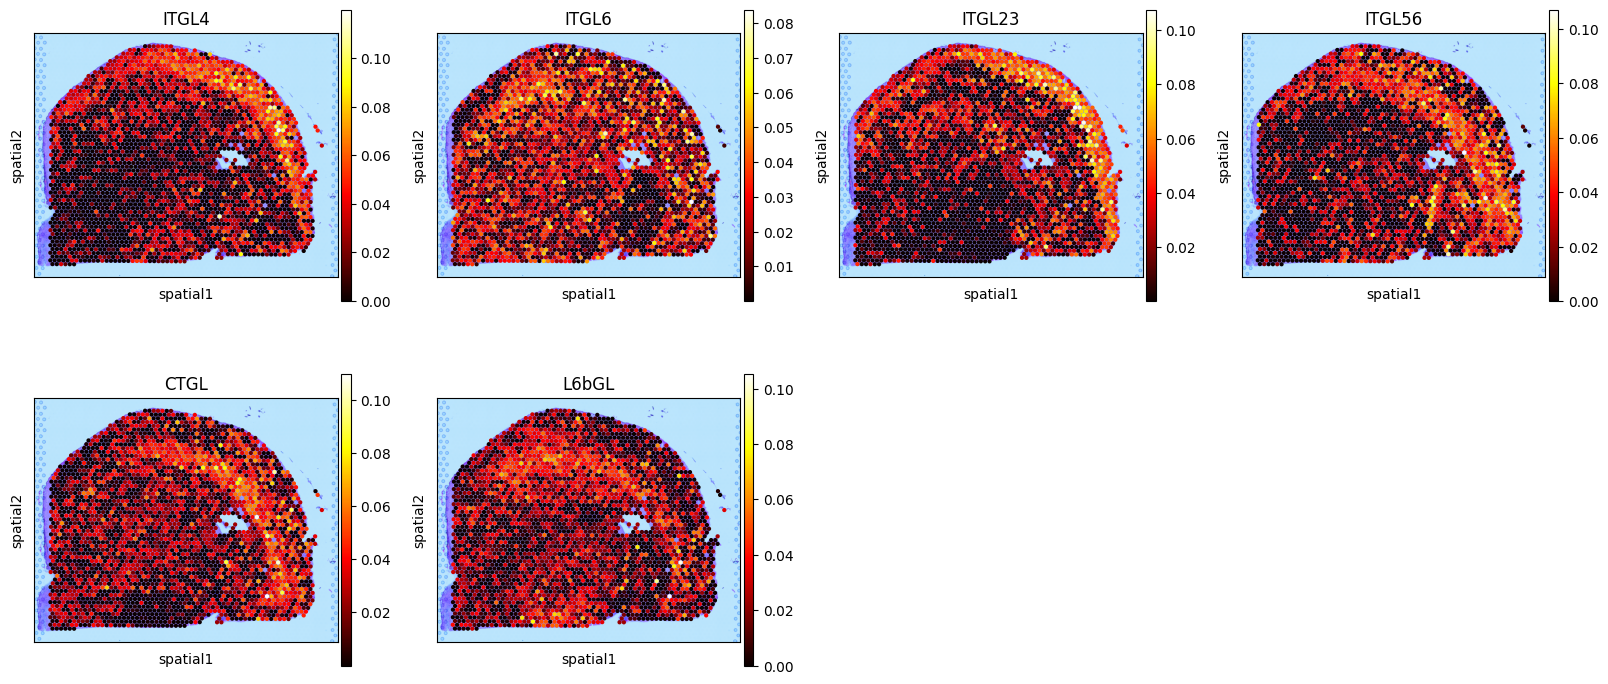

In [117]:
sc.pl.spatial(
    adata_transfer,
    img_key="hires",
    color=['ITGL4', 'ITGL6', 'ITGL23', 'ITGL56', 'CTGL', 'L6bGL'],
    size=1.5,
    cmap='hot'
)

## GO Term Enrichment

To check the GO terms associated with a particular cluster, I first rank the genes according to the new clustering that I have done.

In [76]:
sc.tl.rank_genes_groups(adata, 'sc_annot_broad', method='wilcoxon', use_raw = True)

In [77]:
adata.obs.sc_annot_broad.unique()

['Endothelial_Capillary', 'Epithelial_Glandular', 'Mesenchymal_Airway/Vascular', 'Endothelial_Main', 'Epithelial_Airway', ..., 'Immune_Myeloid', 'Immune_Lymphoid', 'Epithelial_Alveolar', 'Immune_InnateLymphoid', 'Mesenchymal_Pleura']
Length: 11
Categories (11, object): ['Endothelial_Capillary', 'Endothelial_Main', 'Epithelial_Airway', 'Epithelial_Alveolar', ..., 'Immune_Myeloid', 'Mesenchymal_Airway/Vascular', 'Mesenchymal_Alveolar', 'Mesenchymal_Pleura']

I chose to look into the "Mesenchymal_Airway/Vascular" cluster, cell type. Although it is not named as such in the associated paper, it makes sense in the context of the tissue  that the authors used. It also occupies large sections of the tissue, so I felt most confident in it being present, along with the fact that the authors had a similar cell type in their analysis.

Next, I use the built-in scanpy function for enrichment, as follows.

In [79]:
sc.queries.enrich(adata, "Mesenchymal_Airway/Vascular").head(10)

source      native                                      name       p_value  \
0  GO:CC  GO:0005615                       extracellular space  1.453039e-79   
1  GO:CC  GO:0070062                     extracellular exosome  1.772587e-79   
2  GO:CC  GO:1903561                     extracellular vesicle  3.485550e-79   
3  GO:CC  GO:0043230                   extracellular organelle  3.857194e-79   
4  GO:CC  GO:0065010  extracellular membrane-bounded organelle  3.857194e-79   
5  GO:CC  GO:0005576                      extracellular region  4.615630e-70   
6  GO:CC  GO:0031982                                   vesicle  1.335030e-56   
7  GO:BP  GO:0009888                        tissue development  4.528150e-41   
8  GO:CC  GO:0030055                   cell-substrate junction  4.055077e-39   
9  GO:CC  GO:0070161                        anchoring junction  9.070733e-39   

   significant                                        description  term_size  \
0         True  "That part of a multicellular organism outside...       3284   
1         True  "A vesicle that is released into the extracell...       2109   
2         True  "Any vesicle that is part of the extracellular...       2133   
3         True  "Organized structure of distinctive morphology...       2134   
4         True  "Organized structure of distinctive morphology...       2134   
5         True  "The space external to the outermost structure...       4206   
6         True  "Any small, fluid-filled, spherical organelle ...       3976   
7         True  "The process whose specific outcome is the pro...       2004   
8         True  "A cell junction that forms a connection betwe...        431   
9         True  "A cell junction that mechanically attaches a ...        903   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         689                309                  22090   0.448476  0.094093   
1         689                247                  22090   0.358491  0.117117   
2         689                248                  22090   0.359942  0.116268   
3         689                248                  22090   0.359942  0.116214   
4         689                248                  22090   0.359942  0.116214   
5         689                337                  22090   0.489115  0.080124   
6         689                305                  22090   0.442671  0.076710   
7         673                189                  21010   0.280832  0.094311   
8         689                 83                  22090   0.120464  0.192575   
9         689                118                  22090   0.171263  0.130676   

     query                   parents  
0  query_1  [GO:0005576, GO:0110165]  
1  query_1  [GO:0005615, GO:1903561]  
2  query_1  [GO:0031982, GO:0065010]  
3  query_1  [GO:0005576, GO:0043226]  
4  query_1  [GO:0043227, GO:0043230]  
5  query_1              [GO:0110165]  
6  query_1              [GO:0043227]  
7  query_1              [GO:0048856]  
8  query_1              [GO:0070161]  
9  query_1              [GO:0030054]

It is clear that the terms correspond to cells that are located near cellular boundaries and connected to extracellular space, which broadly makes sense here given that we are dealing with lung tissue. Moreover, since these are vascular cells, they would be in contact with extracellular spaces, such as at blood barriers. Overall, this makes sense for this cell type cluster.

## Neighborhood enrichment

We can look to observe interactions between the various cell types, by observing whether the cell types interact in space.

In [61]:
sq.gr.nhood_enrichment(adata, cluster_key="sc_annot_broad")

  0%|          | 0/1000 [00:00<?, ?/s]

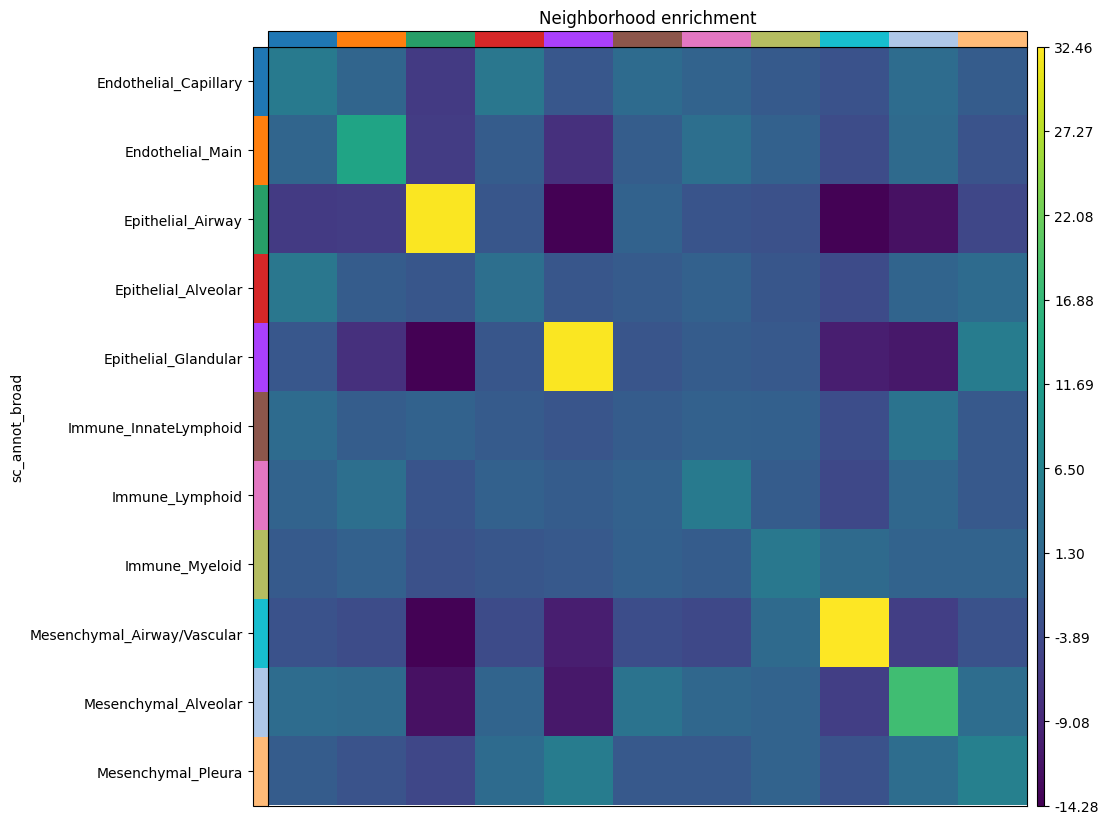

In [63]:
sq.pl.nhood_enrichment(adata, cluster_key="sc_annot_broad" ,figsize=(8,8))